# Building a random forest classifier using MACCS keys to predict if a compound can cross the blood brain barrier

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import MACCSkeys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# EDA and data cleaning

[16:48:37] Explicit valence for atom # 10 C greater than permitted
[16:48:37] ERROR: Could not sanitize molecule ending on line 784435
[16:48:37] ERROR: Explicit valence for atom # 10 C greater than permitted
[16:48:38] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 42 43 44 45 46
[16:48:38] ERROR: Could not sanitize molecule ending on line 924500
[16:48:38] ERROR: Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 42 43 44 45 46
[16:48:41] Explicit valence for atom # 10 C greater than permitted
[16:48:41] ERROR: Could not sanitize molecule ending on line 1209257
[16:48:41] ERROR: Explicit valence for atom # 10 C greater than permitted


,Name,NO.,compound_name,IUPAC_name,CID,logBB,BBB+/BBB-,Inchi,reference,group,...,TPSAScore,HBDScore,HBAScore,PkbScore,PkaScore,CNSchemaxonScore,ID,ROMol,comments,threshold
0,atoms 28 bonds 30,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,5339,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,R2|R2|R25|R46|,A,...,0.0,0.0,0.0,0.5,-2.125,-0.27421428571428574,atoms 28 bonds 30,,NaN,NaN
1,atoms 36 bonds 39,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,3889,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,R25|,A,...,0.0,0.0,0.0,0.5,-0.085,1.415,atoms 36 bonds 39,,NaN,NaN
2,atoms 13 bonds 14,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,2788,-2.4,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,R18|R26|R27|,A,...,0.6559999999999999,0.8333333333333334,1.0,0.5,0.0,5.059333333333333,atoms 13 bonds 14,,NaN,NaN
3,atoms 19 bonds 19,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,14022517,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,...,0.8966666666666668,0.5,0.5,0.5,0.0,4.3966666666666665,atoms 19 bonds 19,,NaN,NaN
4,atoms 41 bonds 46,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",18595497,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,R25|,A,...,0.0,0.0,0.0,0.41500000000000004,0.0,-0.3097642857142856,atoms 41 bonds 46,,NaN,NaN

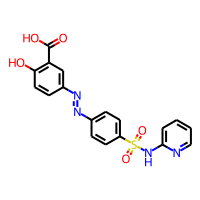
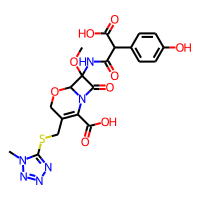
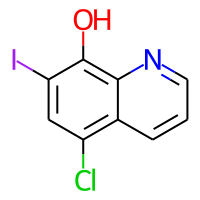
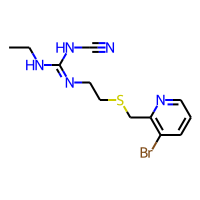
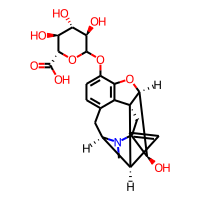

In [2]:
# Load data
raw_df = PandasTools.LoadSDF("AllCNSdata.sdf")
raw_df.head()

,BBB_penetrance,ROMol,smiles
0,BBB-,,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...

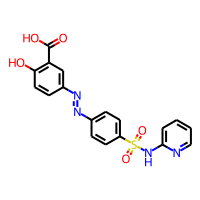

In [3]:
# Select relevant columns
df = raw_df[['BBB+/BBB-', 'ROMol']].copy()
df.columns = ['BBB_penetrance', 'ROMol']
df['smiles'] = df.ROMol.apply(lambda x: Chem.MolToSmiles(x))
df.head(1)

In [4]:
# Check for missing values
df.isna().sum()

BBB_penetrance    0
ROMol             0
smiles            0
dtype: int64

In [5]:
# Check balance of dataset
df["BBB_penetrance"].value_counts()

BBB+    4956
BBB-    2848
Name: BBB_penetrance, dtype: int64

In [6]:
# Check for duplicated values
df.smiles.duplicated().value_counts()

False    7699
True      105
Name: smiles, dtype: int64

In [7]:
# Checking for duplicates with conflicts
smiles_conflict = []
idx_conflict = []

for smiles in df['smiles'].unique() :

    
    outcomes = df[ df.smiles == smiles ].BBB_penetrance.unique()
    
    if len(outcomes) > 1 :
        
        idx_tmp = df.index[ df.smiles == smiles ].tolist()
        idx_conflict.extend(idx_tmp)
        smiles_conflict.append(smiles)

print("#", len(smiles_conflict), "SMILES strings with conflicting activities, associated with", len(idx_conflict), "entries.")

# 4 SMILES strings with conflicting activities, associated with 9 entries.


In [8]:
# Removing conflicts
df = df.drop(idx_conflict)

In [9]:
df = df.drop_duplicates(subset='smiles')  # remove duplicate rows except for the first occurring row.
df.BBB_penetrance.value_counts()

BBB+    4893
BBB-    2802
Name: BBB_penetrance, dtype: int64

# Generating data

In [10]:
fps=dict()

for idx, row in df.iterrows() :
     fps[idx] = list(MACCSkeys.GenMACCSKeys(row.ROMol).ToBitString())

In [11]:
# Generate column names
fpbitnames = []

for i in range(0,167):   # from MACCS000 to MACCS166
    fpbitnames.append( "MACCS" + str(i).zfill(3) )

df_fps = pd.DataFrame.from_dict(fps, orient='index', columns=fpbitnames)
df_fps['BBB_penetrance'] = df.BBB_penetrance.to_list()
df_fps.BBB_penetrance = [ 0 if x == 'BBB-' else 1 for x in df['BBB_penetrance'] ]
df_fps.head()

,MACCS000,MACCS001,MACCS002,MACCS003,MACCS004,MACCS005,MACCS006,MACCS007,MACCS008,MACCS009,...,MACCS158,MACCS159,MACCS160,MACCS161,MACCS162,MACCS163,MACCS164,MACCS165,MACCS166,BBB_penetrance
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0


In [12]:
df_fps.BBB_penetrance.value_counts()

1    4893
0    2802
Name: BBB_penetrance, dtype: int64

# Training Classifier

In [13]:
X = df_fps.iloc[:,:-1]
y = df_fps['BBB_penetrance'].values

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(5386, 167) (2309, 167) (5386,) (2309,)
3425 1468


100%|███████████████████████████████████████████| 36/36 [00:14<00:00,  2.42it/s]


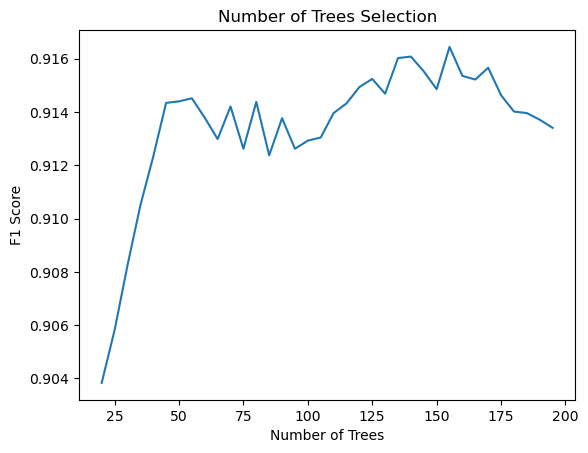

Best number of trees: 155


In [15]:
f1_scores = []
array = np.arange(20,200,5)
for number_trees in tqdm(array):
    RFCls = RandomForestClassifier(n_estimators = number_trees, random_state = 0)
    RFCls.fit(X_train,y_train)
    f1_scores.append(f1_score(y_test, RFCls.predict(X_test)))
    
plt.plot(array, f1_scores)
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('Number of Trees Selection')
plt.show()

best_alpha = array[max(range(len(f1_scores)), key=f1_scores.__getitem__)]

print(f"Best number of trees: {best_alpha}")

In [22]:
def performance_analysis(model):
    from sklearn.metrics import f1_score
    
    y_true, y_pred = y_train, model.predict(X_train)
    CMat = confusion_matrix( y_true, y_pred )
    
    print("Using Training Data")
    print("Confusion Matrix")
    print(CMat, '\n')    # [[TN, FP],[FN, TP]]
    acc  = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    y_score = model.predict_proba(X_train)[:, 1]
    auc = roc_auc_score(y_true, y_score)
    print(f"Accuracy: {acc}\nF1 Score: {f1}\nROC AUC {auc}\n")
    
    y_true, y_pred = y_test, model.predict(X_test)
    CMat = confusion_matrix( y_true, y_pred )
    
    print("Using Test Data")
    print("Confusion Matrix")
    print(CMat, '\n')    # [[TN, FP],[FN, TP]]
    acc  = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    y_score = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_true, y_score)
    print(f"Accuracy: {acc}\nF1 Score: {f1}\nROC AUC {auc}")
    print("\n")
    print(classification_report(y_true, y_pred))

In [17]:
maccs_rf_clf = RandomForestClassifier(n_estimators = best_alpha, random_state = 0)
maccs_rf_clf.fit(X_train ,y_train)

performance_analysis(maccs_rf_clf)

Using Training Data
Confusion Matrix
[[1920   41]
 [  50 3375]] 

Accuracy: 0.9831043445971036
F1 Score: 0.9866978511913463
ROC AUC 0.9983772617128904

Using Test Data
Confusion Matrix
[[ 688  153]
 [  97 1371]] 

Accuracy: 0.89172802078822
F1 Score: 0.9164438502673796
ROC AUC 0.9571363078209086


              precision    recall  f1-score   support

           0       0.88      0.82      0.85       841
           1       0.90      0.93      0.92      1468

    accuracy                           0.89      2309
   macro avg       0.89      0.88      0.88      2309
weighted avg       0.89      0.89      0.89      2309



In [18]:
import pickle

filename = 'BBB_classifier_maccs_rf.sav'
# pickle.dump(maccs_rf_clf, open(filename, 'wb'))

<AxesSubplot: >

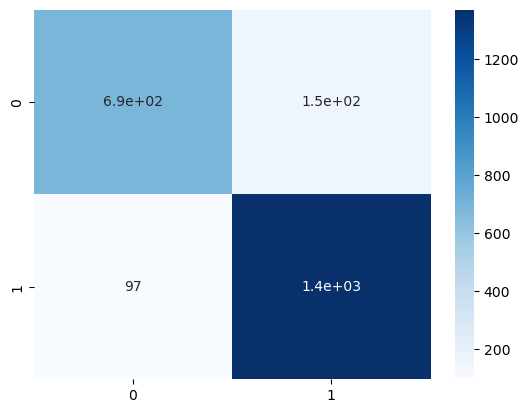

In [29]:
import seaborn as sns
sns.heatmap(CMat, annot=True, 
             cmap='Blues')

In [28]:
y_true, y_pred = y_test, maccs_rf_clf.predict(X_test)
CMat = confusion_matrix( y_true, y_pred )